In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


#### Check the availability of GPU

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### Load dataset

In [4]:
data = pd.read_csv('mnist_train.csv')
data.head(), type(data), data.shape

(   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
 0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
 1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
 2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
 3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
 4      9    0    0    0    0    0    0    0    0    0  ...      0      0   
 
    28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
 0      0      0      0      0      0      0      0      0  
 1      0      0      0      0      0      0      0      0  
 2      0      0      0      0      0      0      0      0  
 3      0      0      0      0      0      0      0      0  
 4      0      0      0      0      0      0      0      0  
 
 [5 rows x 785 columns],
 pandas.core.frame.DataFrame,
 (60000, 785))

#### MNIST dataset
- Contains images of handwritten digits (0-9)
- size of each image is 28 x 28 (pixels) and is gray scale
    - So the input features = 1 x 28 x 28 = 784 pixels
    - the classes (0-9) = 10 classes

#### Transform data to numpy

In [5]:
data = np.array(data)

In [6]:
X = data[:, 1:]
y = data[:, 0]

X.shape, y.shape, type(X), type(y)

((60000, 784), (60000,), numpy.ndarray, numpy.ndarray)

#### Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Convert to tensor

In [8]:
X_t = torch.tensor(X_train, dtype=torch.float32)
y_t = torch.tensor(y_train, dtype=torch.long)

X_train = X_t
y_train = y_t
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

#### Normalize the data

In [9]:
X_train = X_train/torch.max(X_train)
X_test = X_test/torch.max(X_test)

#### Convert to pytorch dataset

In [10]:
X_train = TensorDataset(X_train, y_train)
X_test = TensorDataset(X_test, y_test)

#### Move data into dataloader objects

In [11]:
batchSize = 32
train_loader = DataLoader(X_train, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(X_test, batch_size=X_test.tensors[0].shape[0])

In [12]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 784]) torch.Size([32])


#### Visualize

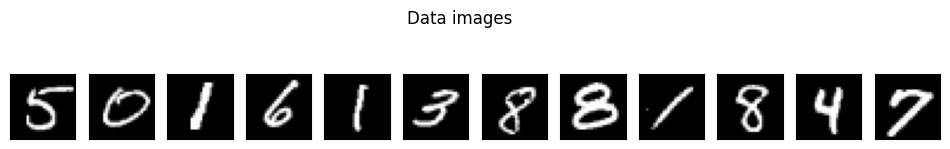

In [13]:
fig, axs = plt.subplots(1, 12,figsize=(12,2))
for i in range(12):
    axs[i].imshow(X_t[i,:].view(28, 28).detach(), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.suptitle('Data images')
plt.show()

#### Create neural network

In [14]:
class NN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 32)
        
        # classification or output layer
        self.output = nn.Linear(32, 10)
    # Forward pass
    def forward(self, x):
        x = self.input(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        # output layer
        x = self.output(x)
        
        return x
model = NN_Classifier()

#### Train Model

In [15]:
learningRate = 0.01
momentum = 0.9
lossfc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=learningRate)

model.to(device)

NN_Classifier(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [16]:
epochs = 250
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []

for epoch in range(epochs):
    model.train()
    # Loop for training in batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
        X = X.to(device) # Placing features on device
        y = y.to(device) # placing labels on device
        ypred = model(X)
        loss = lossfc(ypred,y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Append batchloss
        batchLoss.append(loss.item())
        ypred = ypred.cpu() # Back to cpu
        y = y.cpu()
        # compute batch accuracy
        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc)
    # Average training accuracy (Outside the batchloop)
    trainAcc.append(np.mean(batchAcc))
    # Losses through epochs
    losses[epoch] = np.mean(batchLoss)
    
    
    # TESTING the model
    model.eval()
    X,y = next(iter(test_loader))
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): #This step  Deactivating autogradient
        ypred = model(X)
        ypred = ypred.cpu()
        y = y.cpu()
        # Appending test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
        if (epoch % 10) == 0:
            print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.27
 epochs : 10  loss :  0.17
 epochs : 20  loss :  0.07
 epochs : 30  loss :  0.00
 epochs : 40  loss :  0.01
 epochs : 50  loss :  0.13
 epochs : 60  loss :  0.16
 epochs : 70  loss :  0.00
 epochs : 80  loss :  0.02
 epochs : 90  loss :  0.01
 epochs : 100  loss :  0.13
 epochs : 110  loss :  0.03
 epochs : 120  loss :  0.00
 epochs : 130  loss :  0.00
 epochs : 140  loss :  0.00
 epochs : 150  loss :  0.01
 epochs : 160  loss :  0.00
 epochs : 170  loss :  0.00
 epochs : 180  loss :  0.01
 epochs : 190  loss :  0.01
 epochs : 200  loss :  0.11
 epochs : 210  loss :  0.14
 epochs : 220  loss :  0.01
 epochs : 230  loss :  0.04
 epochs : 240  loss :  0.03


# Visualizing the Loss and Accuracies

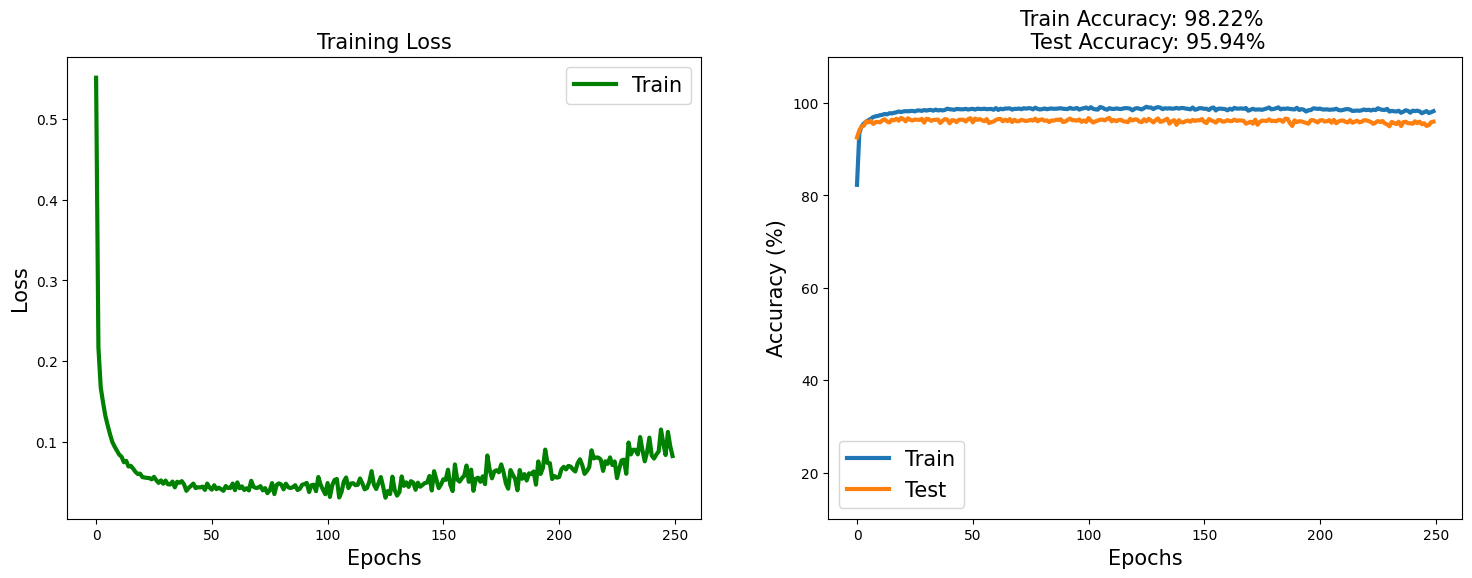

In [17]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [33]:
ypred_1 = model(X)
ypred_1

tensor([[-32.2840,  14.8702,  -3.5003,  ...,  70.7842,   3.2119,  20.0739],
        [ 28.9827,  43.5031,  11.9296,  ...,   5.3587,  45.0040,  21.9867],
        [ -9.1698, -29.6571,   6.9728,  ..., -37.6591,  66.5169, -13.8933],
        ...,
        [-31.9442, -11.1652, -13.2676,  ...,  13.1051,   0.4264,  26.0461],
        [-19.7785,   7.8153,  -5.2616,  ...,  34.1863,   0.3480,  14.6345],
        [ -3.9428,  -1.1619,  14.5034,  ...,   3.1694,  -2.2870,  -5.3581]],
       grad_fn=<AddmmBackward0>)

#### Save the model (Method 1)

In [30]:
torch.save(model.state_dict(), 'nn_mnist_classification.pt')

#### Load the saved model

In [34]:
model.load_state_dict(torch.load('nn_mnist_classification.pt'))

C:\Users\divya\AppData\Local\Temp\ipykernel_15908\2984902057.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('nn_mnist_classification.pt

<All keys matched successfully>

#### Test loaded model

In [35]:
model.to(device)
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

print(X, y)
with torch.no_grad(): #This step  Deactivating autogradient
    ypred = model(X)
    ypred = ypred.cpu()
    y = y.cpu()
acc = 100 * torch.mean((torch.argmax(ypred,dim=1)==y).float())
print(acc)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 3, 8,  ..., 9, 7, 2])
tensor(95.9417)


#### Save the model (Method 2)

In [36]:
NewModel = NN_Classifier()

#### Transfer weights of the trained model to new model

In [37]:
NewModel.load_state_dict(torch.load('nn_mnist_classification.pt'))

C:\Users\divya\AppData\Local\Temp\ipykernel_15908\2399522477.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NewModel.load_state_dict(torch.load('nn_mnist_classification

<All keys matched successfully>

In [38]:
NewModel.to(device)
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

with torch.no_grad(): #This step  Deactivating autogradient
    ypred = NewModel(X)
    ypred = ypred.cpu()
    y = y.cpu()
    # Appending test accuracy
acc = 100 * torch.mean((torch.argmax(ypred,dim=1)==y).float())
acc

tensor(95.9417)